In [1]:
import warnings

from compare_variance_residual.simulated.simulation import plot_variance_vs_residual

warnings.simplefilter(action='ignore')
import numpy as np

from variance_partitioning import variance_partitioning
from himalaya.progress_bar import bar
from residual import residual_method
from simulation import generate_dataset
import matplotlib.pyplot as plt

In [2]:
from himalaya.backend import set_backend

backend = set_backend("cupy", on_error="warn")

# Set default values to be used in the tests

In [3]:
n_observations = 5
n_runs = 1
unique_contributions = [0.6, 0.2]
n_features_list = [100, 100]
n_targets = 100
n_samples_train = 100
n_samples_test = 100
noise_level = 0.0
random_distribution = "normal"
ignore_negative_r2 = True

use_refinement = True
use_ols = False

# Test varying sample sizes

In [4]:
n_sample_sizes = n_observations
sample_sizes = np.logspace(1, 3, n_sample_sizes)

In [5]:
predicted_varying_samples_variance = []
predicted_varying_samples_residual = []

for sample_size in bar(sample_sizes, title=f"varying sample sizes"):
    sample_size = int(sample_size)
    variance_runs = []
    residual_runs = []
    for run in range(n_runs):
        (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
            n_features_list=n_features_list, n_targets=n_targets,
            n_samples_train=sample_size, n_samples_test=sample_size,
            noise=noise_level, unique_contributions=unique_contributions,
            random_distribution=random_distribution, random_state=run + 100)

        predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=use_refinement,
                                                   ignore_negative_r2=ignore_negative_r2)
        predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=use_ols,
                                             ignore_negative_r2=ignore_negative_r2)
        variance_runs.append(predicted_variance)
        residual_runs.append(predicted_residual)
    predicted_varying_samples_variance.append(np.median(variance_runs))
    predicted_varying_samples_residual.append(np.median(residual_runs))

[........................................] 100% | 12.35 sec | varying sample sizes | 


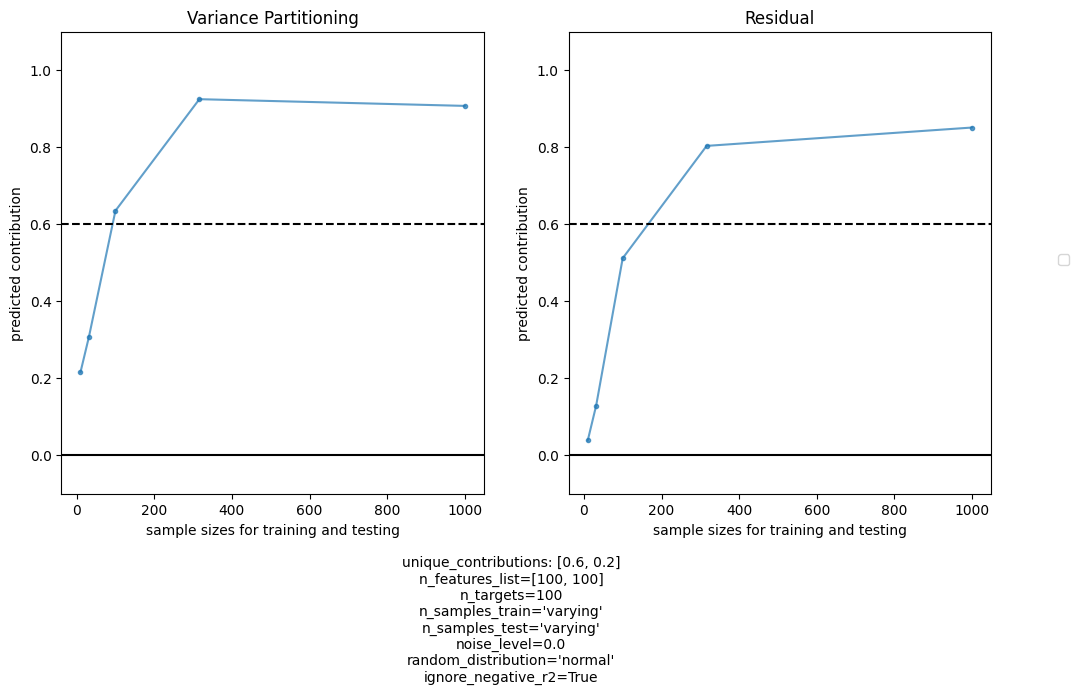

In [6]:
plot_variance_vs_residual(sample_sizes, "sample sizes for training and testing", predicted_varying_samples_variance,
                          predicted_varying_samples_residual, unique_contributions, n_features_list=n_features_list,
                          n_targets=n_targets, n_samples_train="varying", n_samples_test="varying",
                          noise_level=noise_level, random_distribution=random_distribution,
                          ignore_negative_r2=ignore_negative_r2)

# Test varying feature sizes

In [7]:
n_feature_sizes = n_observations
feature_sizes = np.logspace(0, 4, n_feature_sizes)

In [8]:
predicted_varying_feature_variance = []
predicted_varying_feature_residual = []

for feature_size in bar(feature_sizes, title=f"varying feature sizes"):
    feature_size = int(feature_size)
    variance_runs = []
    residual_runs = []
    for run in range(n_runs):
        (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
            n_features_list=[feature_size, feature_size], n_targets=n_targets,
            n_samples_train=n_samples_train, n_samples_test=n_samples_test,
            noise=noise_level, unique_contributions=unique_contributions,
            random_distribution=random_distribution, random_state=run + 100)

        predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=use_refinement,
                                                   ignore_negative_r2=ignore_negative_r2)
        predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=use_ols,
                                             ignore_negative_r2=ignore_negative_r2)
        variance_runs.append(predicted_variance)
        residual_runs.append(predicted_residual)
    predicted_varying_feature_variance.append(np.median(variance_runs))
    predicted_varying_feature_residual.append(np.median(residual_runs))

[........................................] 100% | 10.46 sec | varying feature sizes | 


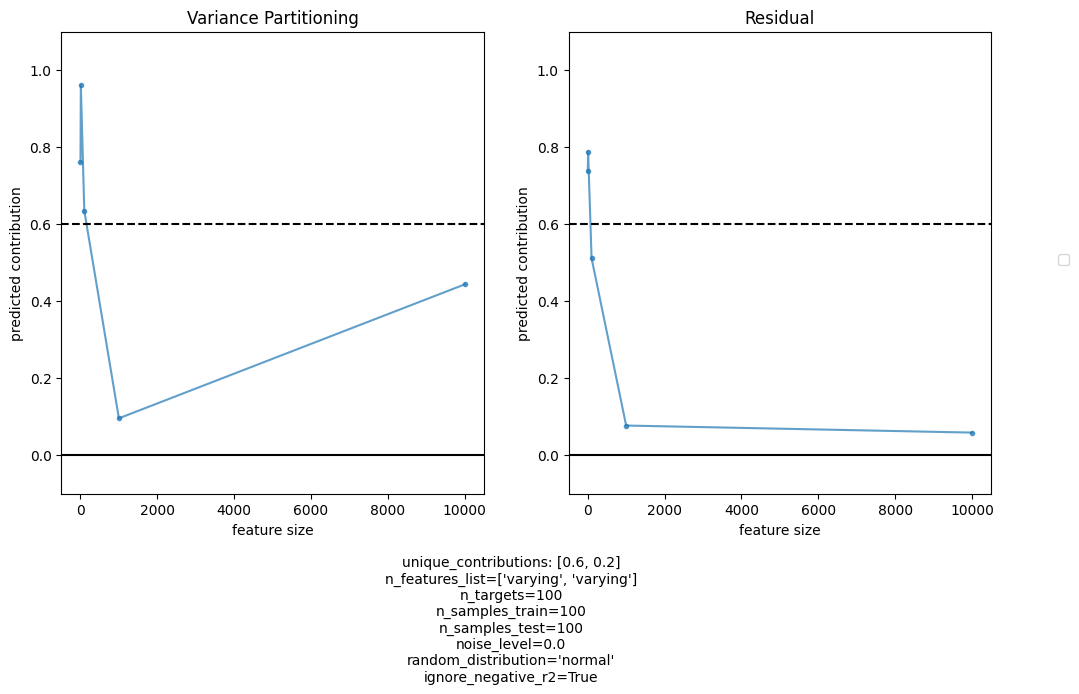

In [9]:
plot_variance_vs_residual(feature_sizes, "feature size", predicted_varying_feature_variance,
                          predicted_varying_feature_residual, unique_contributions,
                          n_features_list=["varying", "varying"], n_targets=n_targets, n_samples_train=n_samples_train,
                          n_samples_test=n_samples_test, noise_level=noise_level,
                          random_distribution=random_distribution, ignore_negative_r2=ignore_negative_r2)

# Test varying ratios between feature sizes and target sizes

In [10]:
n_target_sizes = n_observations
target_sizes = np.logspace(0, 4, n_target_sizes)

In [11]:
predicted_varying_target_variance = []
predicted_varying_target_residual = []

for target_size in bar(target_sizes, title=f"varying target ratios"):
    target_size = int(target_size)

    variance_runs = []
    residual_runs = []
    for random_state in range(n_runs):
        (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
            n_features_list=n_features_list, n_targets=target_size,
            n_samples_train=n_samples_train, n_samples_test=n_samples_test,
            noise=noise_level, unique_contributions=unique_contributions,
            random_distribution=random_distribution, random_state=random_state)

        predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=use_refinement,
                                                   ignore_negative_r2=ignore_negative_r2)
        predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=use_ols,
                                             ignore_negative_r2=ignore_negative_r2)
        variance_runs.append(predicted_variance)
        residual_runs.append(predicted_residual)
    predicted_varying_target_variance.append(np.median(variance_runs))
    predicted_varying_target_residual.append(np.median(residual_runs))

[........................................] 100% | 17.74 sec | varying target ratios | 


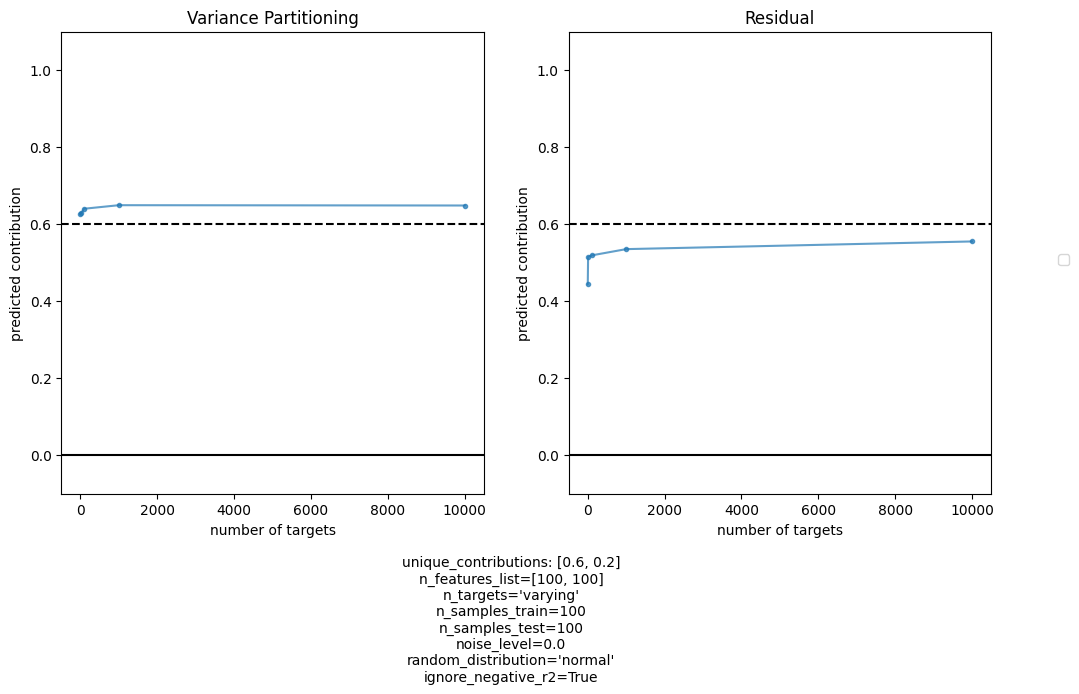

In [12]:
plot_variance_vs_residual(target_sizes, "number of targets", predicted_varying_target_variance,
                          predicted_varying_target_residual, unique_contributions, n_features_list=n_features_list,
                          n_targets="varying", n_samples_train=n_samples_train, n_samples_test=n_samples_test,
                          noise_level=noise_level, random_distribution=random_distribution,
                          ignore_negative_r2=ignore_negative_r2)

# Test varying noise levels

In [13]:
n_noise_levels = n_observations
noise_levels = np.linspace(0, 1, n_noise_levels)

In [14]:
predicted_varying_noise_variance = []
predicted_varying_noise_residual = []

for noise in bar(noise_levels, title=f"Testing noise levels: {noise_levels}"):
    variance_runs = []
    residual_runs = []
    for random_state in range(n_runs):
        (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
            n_features_list=n_features_list, n_targets=n_targets,
            n_samples_train=n_samples_train, n_samples_test=n_samples_test,
            noise=noise, unique_contributions=unique_contributions,
            random_distribution=random_distribution,
            random_state=1)

        predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=use_refinement,
                                                   ignore_negative_r2=ignore_negative_r2)
        predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=use_ols,
                                             ignore_negative_r2=ignore_negative_r2)
        variance_runs.append(predicted_variance)
        residual_runs.append(predicted_residual)
    predicted_varying_noise_variance.append(np.median(variance_runs))
    predicted_varying_noise_residual.append(np.median(residual_runs))

[........................................] 100% | 12.65 sec | Testing noise levels: [0.   0.25 0.5  0.75 1.  ] | 


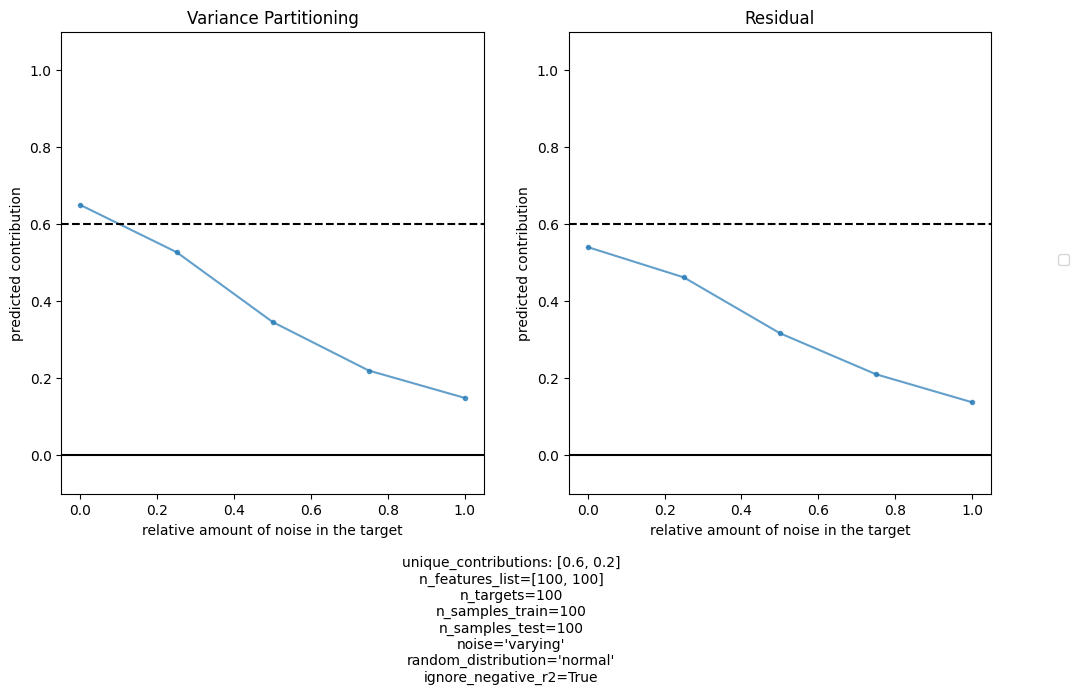

In [15]:
plot_variance_vs_residual(noise_levels, "relative amount of noise in the target", predicted_varying_noise_variance,
                          predicted_varying_noise_residual, unique_contributions, n_features_list=n_features_list,
                          n_targets=n_targets, n_samples_train=n_samples_train, n_samples_test=n_samples_test,
                          noise="varying", random_distribution=random_distribution,
                          ignore_negative_r2=ignore_negative_r2)

# Test varying unique contributions of $X_0$ and $X_1$

In [16]:
n_contributions = n_observations
x0_unique_contributions = np.linspace(0, 1, n_contributions)

In [ ]:
# Initialize predicted_variance and predicted_residual with separate lists
predicted_varying_contribution_variance = [[0] * n_contributions for _ in range(n_contributions)]
predicted_varying_contribution_residual = [[0] * n_contributions for _ in range(n_contributions)]

# create 2d data with unique contribution of X0 and X1 varying
for x0, x0_unique_contribution in enumerate(x0_unique_contributions):
    for x1 in bar(range(n_contributions), title=f"X0: {x0_unique_contribution}"):
        variance_runs = []
        residual_runs = []

        for random_state in range(n_runs):
            X1_unique_contribution = (1 - x0_unique_contribution) * x1 / (n_contributions - 1)
            (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
                n_features_list=n_features_list, n_targets=n_targets,
                n_samples_train=n_samples_train, n_samples_test=n_samples_test,
                noise=noise_level, unique_contributions=[x0_unique_contribution, X1_unique_contribution],
                random_distribution=random_distribution,
                random_state=random_state)

            predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test,
                                                       use_refinement=use_refinement,
                                                       ignore_negative_r2=ignore_negative_r2)
            predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=use_ols,
                                                 ignore_negative_r2=ignore_negative_r2)
            variance_runs.append(predicted_variance)
            residual_runs.append(predicted_residual)

        predicted_varying_contribution_variance[x1][x0] = np.median(variance_runs)
        predicted_varying_contribution_residual[x1][x0] = np.median(residual_runs)

[........................................] 100% | 11.76 sec | X0: 0.0 | 
[........................................] 100% | 14.90 sec | X0: 0.25 | 
[........                                ] 20% | 2.99 sec | X0: 0.5 | 

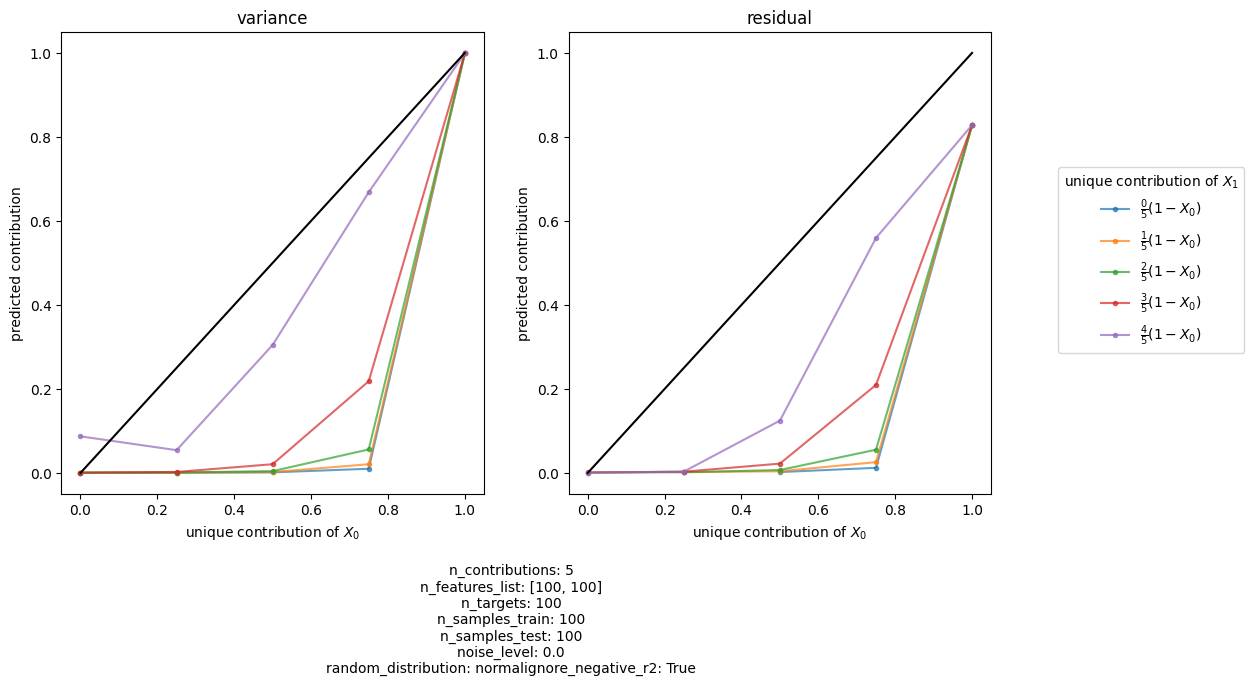

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
handles, labels = [], []

for ax, predicted, method in zip(axs,
                                 [predicted_varying_contribution_variance, predicted_varying_contribution_residual],
                                 ["variance", "residual"]):
    for x1, x0_unique_contribution in enumerate(x0_unique_contributions):
        X1_unique_contribution = (1 - x0_unique_contribution) * x1 / (n_contributions - 1)
        line, = ax.plot(x0_unique_contributions, predicted[x1], alpha=0.7,
                        label=fr"$\frac{{{x1}}}{{{n_contributions}}}(1-X_0)$", marker=".")

        if method == "variance":
            handles.append(line)
            labels.append(line.get_label())
    ax.plot(x0_unique_contributions, x0_unique_contributions, color="black")

    ax.set_xlabel(r"unique contribution of $X_0$")
    ax.set_ylabel("predicted contribution")
    # ax.legend(title=r"unique contribution of $X_1$")
    ax.set_title(f"{method}")
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([-0.05, 1.05])

fig.legend(handles, labels, title=r"unique contribution of $X_1$", loc='center left', bbox_to_anchor=(0.95, 0.5))

# Collect variable information
variable_info = f"n_contributions: {n_contributions}\n" \
                f"n_features_list: {n_features_list}\n" \
                f"n_targets: {n_targets}\n" \
                f"n_samples_train: {n_samples_train}\n" \
                f"n_samples_test: {n_samples_test}\n" \
                f"noise_level: {noise_level}\n" \
                f"random_distribution: {random_distribution}" \
                f"ignore_negative_r2: {ignore_negative_r2}"
# Add text field with variable information
fig.text(0.5, -0.1, variable_info, ha='center', va='center', fontsize=10)

plt.show()